In [1]:
import os
import email
import re
import mailparser
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
from tld import get_tld
from time import strftime, strptime, time
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, confusion_matrix, roc_curve, auc
from itertools import product
from sklearn.preprocessing import label_binarize

Set constants for directories, take a random sampling of the "ignore" email since there are so many (under sample)

In [2]:
IGNORE_DIR = '/Users/worshamn/Documents/emailProject/IgnoreFix'
INVESTIGATE_DIR = '/Users/worshamn/Documents/emailProject/InvestigateFix'
#https://stackoverflow.com/a/6482922
random.seed(2842)
ignore_sample_index = [ i for i in sorted(random.sample(range(len(os.listdir(IGNORE_DIR))), 400)) ]
ignore_sample = []
for i in ignore_sample_index:
    ignore_sample.append(os.listdir(IGNORE_DIR)[i])
input_dirs = {}
input_dirs[INVESTIGATE_DIR] = os.listdir(INVESTIGATE_DIR) 
input_dirs[IGNORE_DIR] = ignore_sample

In [3]:
len(input_dirs)

2

In [4]:
len(input_dirs[INVESTIGATE_DIR])

384

In [5]:
len(input_dirs[IGNORE_DIR])

400

Build function to extract text and features

In [6]:
def get_email_text(file):
    d = {}
    raw_message = email.message_from_file(file)
    mail = mailparser.parse_from_string(raw_message.as_string())
    d['subject'] = mail.subject
    d['subject_len'] = len(d['subject'])
    if raw_message.is_multipart():
        d['is_mulitpart'] = 1
    else:
        d['is_multipart'] = 0
    d['body'] = mail.text_plain
    if len(d['body']) > 0:
        d['mail_text'] = d['subject'] + ' ' + d['body'][0]
        d['body_len'] = len(d['body'][0])
        if len(d['body']) > 1:
            soup_html = BeautifulSoup(d['body'][1],'lxml')
            d['links'] = soup_html.find_all('a')
            d['num_link'] = len(d['links'])
            links = []
            d['masq_link'] = []
            d['masq_link_tld'] = []
            d['num_email_link'] = 0
            for link in d['links']:
                link_text = link.get_text().rstrip('\n')
                a_link = link.get('href')
                links.append(a_link)
                if 'unsubscribe' in link_text.lower():
                    d['has_unsubscribe_link'] = 1
                if a_link:    
                    if re.search('mailto:',a_link):
                        d['num_email_link'] += 1
                if a_link != link_text and \
                    'http' in link_text.lower() and \
                    not 'alt="http' in link_text.lower():
                        d['masq_link'].append(link)
                        d['masq_link_tld'].append(
                            get_tld(
                                a_link,
                                fix_protocol=True, 
                                fail_silently=True
                            )
                        )
            d['num_uniq_link'] = len(set(links))
            if d['num_link'] > d['num_uniq_link']:
                d['has_repeatlink'] = 1
            else:
                d['has_repeatlink'] = 0
            if len(d['masq_link']) == 0:
                d['masq_link'] = ''
                d['masq_link_tld'] = ''
                d['has_masq_link'] = 0
            else:    
                d['has_masq_link'] = 1
                d['num_masq_link'] = len(d['masq_link'])
    else:
        d['mail_text'] = d['subject']
        d['body_len'] = len(d['body'])
    url_query = '((?:https?|ftp)://[^\s/$.?#]+\.[^\s>]+)'
    d['url'] = re.findall(url_query,d['mail_text'])
    email_query = '([\w.]+@[\w.]+\.[\w.]{2,5})'
    d['email'] = re.findall(email_query,d['mail_text'])
    if d['url']:
        d['has_url'] = 1
        d['num_url'] = len(d['url'])
        d['num_uniq_url'] = len(set(d['url']))
        d['num_url_repeats'] = d['num_url'] - d['num_uniq_url']
        d['url_len'] = []
        d['url_tld'] = []
        for i in d['url']:
            d['url_len'].append(len(i))
            d['url_tld'].append(
                get_tld(i, fix_protocol=True, fail_silently=True)
            )
            d['uniq_url_tld'] = set(d['url_tld'])
    else:
        d['url'] = ''
        d['has_url'] = 0
        d['num_url'] = 0
        d['num_uniq_url'] = 0
        d['url_len'] = 0
        d['url_tld'] = 0
        d['uniq_url_tld'] = 0
        d['num_url_repeats'] = 0
    if d['email']:
        d['has_email'] = 1
        d['num_email_addr'] = len(d['email'])
        d['num_uniq_email'] = len(set(d['email']))
    else:
        d['email'] = ''
        d['has_email'] = 0
        d['num_email_addr'] = 0
        d['num_uniq_email'] = 0
    soup = BeautifulSoup(d['mail_text'],'lxml')
    try:
        d['mail_text'] = soup.get_text().encode(
            'utf-8',
            'ignore'
        ).decode('unicode_escape').replace('\n',' ').replace('\t',' ')
    except:
        d['mail_text'] = soup.get_text().replace('\n',' ').replace('\t',' ')
    d['reply_to'] = mail.reply_to
    for k,v in mail.headers.items():
        d[k] = v
    d['body'] = mail.body
    d['text_plain'] = mail.text_plain
    if mail.attachments:
        d['has_attachments'] = 1
        d['num_attachments'] = len(mail.attachments)
        for i in mail.attachments:
            try:
                d['attachment_filename'].append(i['filename'])
            except:
                d['attachment_filename'] = []
                d['attachment_filename'].append(i['filename'])
            try:
                d['attachment_content_type'].append(i['mail_content_type'])
            except:
                d['attachment_content_type'] = []
                d['attachment_content_type'].append(i['mail_content_type'])
    else:
        d['has_attachments'] = 0
    if re.search(tryGetKeyValue(d, 'Return-Path'),tryGetKeyValue(d, 'From')):
        d['return_path_match_from'] = 1
    else:
        d['return_path_match_from'] = 0
    tld_match = re.match(
            '[^@]+@([^>]+)>',
            tryGetKeyValue(d, 'From')
        )
    if tld_match:
        d['from_tld'] = get_tld(
            tld_match.group(1),
            fix_protocol=True, 
            fail_silently=True
        )
    if 'content="text/html' in d['body'].lower():
        d['has_html_content'] = 1
    else:
        d['has_html_content'] = 0
    if 'script type="text/javascript' in d['body'].lower():
        d['has_javascript'] = 1
    else:
        d['has_javascript'] = 0
    if 'img src="cid:' in d['body'].lower():
        d['has_inline_img'] = 1
    else:
        d['has_inline_img'] = 0
    if 'Content-type' in d:
        d['Content-type'] = re.match('([^;]+);',d['Content-type']).group(1)
    else:
        d['Content-type'] = None
    if 'Date' in d:
        #d['DOTW'] = strftime('%a',strptime(d['Date'],'%a, %d %b %Y %H:%M:%S %z'))
        d['DOTW'] = strftime('%w',strptime(d['Date'],'%a, %d %b %Y %H:%M:%S %z'))
        d['HOTD'] = strftime('%H',strptime(d['Date'],'%a, %d %b %Y %H:%M:%S %z'))
    if mail.has_defects:
        d['has_defects'] = 1
    else:
        d['has_defects'] = 0
    return d

Build function to set the target value based on the directory

In [7]:
def get_target(d):
    if d == IGNORE_DIR:
        return 'ignore'
    elif d == INVESTIGATE_DIR:
        return 'investigate'

Build function to extract value only if the key exists

In [8]:
def tryGetKeyValue(d, key, return_value=''):
  """Attempts to return value of key from dictionary
  """
  try:
    return d[key]
  except:
    return return_value

Create dataframe, iterate through directories and add email features

In [9]:
df = pd.DataFrame()
for d,v in input_dirs.items():
    for f in input_dirs[d]:
        print(d, f)
        with open(os.path.join(d,f),'r',encoding='utf-8', errors='ignore') as raw_mail:
            mail_dict = get_email_text(raw_mail)
            df = df.append(
                {
                    #'filename': f,
                    #'text': mail_dict['mail_text'],
                    'target': get_target(d),
                    'subject_len': mail_dict['subject_len'],
                    'body_len': mail_dict['body_len'],
                    'has_attachments': tryGetKeyValue(mail_dict, 'has_attachments',0),
                    'num_attachments': tryGetKeyValue(mail_dict, 'num_attachments',0),
                    #'attachment_filename': tryGetKeyValue(mail_dict, 'attachment_filename'),
                    #'attachment_content_type': tryGetKeyValue(mail_dict, 'attachment_content_type'),
                    'DKIM': tryGetKeyValue(mail_dict, 'X-BAEAI-DKIM'),
                    'DMARC': tryGetKeyValue(mail_dict, 'X-BAEAI-DMARC'),
                    'SPF': tryGetKeyValue(mail_dict, 'X-BAEAI-SPF'),
                    'return_path_match_from': mail_dict['return_path_match_from'],
                    'from_tld': tryGetKeyValue(mail_dict, 'from_tld'),
                    'Content-type': mail_dict['Content-type'],
                    'DOTW': tryGetKeyValue(mail_dict, 'DOTW'),
                    'HOTD': tryGetKeyValue(mail_dict, 'HOTD'),
                    #'url': mail_dict['url'],
                    'has_url': tryGetKeyValue(mail_dict, 'has_url',0),
                    'num_url': tryGetKeyValue(mail_dict, 'num_url',0),
                    'num_uniq_url': tryGetKeyValue(mail_dict, 'num_uniq_url',0),
                    #'email': tryGetKeyValue(mail_dict, 'email'),
                    'has_email': tryGetKeyValue(mail_dict, 'has_email',0),
                    'num_email_addr': tryGetKeyValue(mail_dict, 'num_email_addr',0),
                    'num_uniq_email': tryGetKeyValue(mail_dict, 'num_uniq_email',0),
                    'num_url_repeats': tryGetKeyValue(mail_dict, 'num_url_repeats',0),
                    #'url_len': mail_dict['url_len'],
                    #'url_tld': mail_dict['url_tld'],
                    #'uniq_url_tld': mail_dict['uniq_url_tld'],
                    'has_html_content': tryGetKeyValue(mail_dict, 'has_html_content',0),
                    'has_javascript': tryGetKeyValue(mail_dict, 'has_javascript',0),
                    'has_inline_img': tryGetKeyValue(mail_dict, 'has_inline_img',0),
                    'TAP-Score': tryGetKeyValue(mail_dict, 'X-USANET-TAP-Score',-1),
                    #'links': tryGetKeyValue(mail_dict, 'links'),
                    'num_link': tryGetKeyValue(mail_dict, 'num_link',0),
                    'num_uniq_link': tryGetKeyValue(mail_dict, 'num_uniq_link',0),
                    'has_repeat_link': tryGetKeyValue(mail_dict, 'has_repeat_link',0),
                    #'masq_link': tryGetKeyValue(mail_dict, 'masq_link'),
                    'has_masq_link': tryGetKeyValue(mail_dict, 'has_masq_link',0),
                    'num_masq_link': tryGetKeyValue(mail_dict, 'num_masq_link',0),
                    #'masq_link_tld': tryGetKeyValue(mail_dict, 'masq_link_tld'),
                    'is_multipart': tryGetKeyValue(mail_dict, 'is_mulitpart', 0),
                    'has_defects': mail_dict['has_defects'],
                    'num_email_link': tryGetKeyValue(mail_dict, 'num_email_link',0),
                    'has_unsubscribe_link': tryGetKeyValue(mail_dict, 'has_unsubscribe_link', 0),
                }, 
                ignore_index=True
            )

/Users/worshamn/Documents/emailProject/InvestigateFix [Phish Alert] FW- Goodchem Document.eml
/Users/worshamn/Documents/emailProject/InvestigateFix [Phish Alert] FW- Validate your Office 365 account.eml
/Users/worshamn/Documents/emailProject/InvestigateFix [Phish Alert] FW- INVOICE YAX-80-97157 Tom Jensen.eml
/Users/worshamn/Documents/emailProject/InvestigateFix [Phish Alert] FW- Invoice Problem 3.eml
/Users/worshamn/Documents/emailProject/InvestigateFix [Phish Alert] FW- Invoice from Karen Laman.eml
/Users/worshamn/Documents/emailProject/InvestigateFix [Phish Alert] FW- Case-637290015585-228.eml
/Users/worshamn/Documents/emailProject/InvestigateFix [Phish Alert] FW- 7 Past Due Invoices.eml
/Users/worshamn/Documents/emailProject/InvestigateFix [Phish Alert] FW- lmportant Message.eml
/Users/worshamn/Documents/emailProject/InvestigateFix [Phish Alert] FW- [Spam] Erinnerung an die Rechnungszahlung.eml
/Users/worshamn/Documents/emailProject/InvestigateFix [Phish Alert] FW- Re-[1].eml
/User

/Users/worshamn/Documents/emailProject/InvestigateFix [Phish Alert] FW- Have a wonderful Christmas and a joyous New Year!.eml
/Users/worshamn/Documents/emailProject/InvestigateFix [Phish Alert] FW- CUST. OBD-66-41275 Rodney Cole.eml
/Users/worshamn/Documents/emailProject/InvestigateFix [Phish Alert] FW- Pat due invoice notification.eml
/Users/worshamn/Documents/emailProject/InvestigateFix [Phish Alert] FW- Completed- Please DocuSign these documents.eml
/Users/worshamn/Documents/emailProject/InvestigateFix [Phish Alert] FW- Invoice number 22028027-LFYJ#WDBB-2017 (27 Nov 17) Notification.eml
/Users/worshamn/Documents/emailProject/InvestigateFix [Phish Alert] FW- Inbound- 5 new.eml
/Users/worshamn/Documents/emailProject/InvestigateFix [Phish Alert] FW- Past due invoice .eml
/Users/worshamn/Documents/emailProject/InvestigateFix [Phish Alert] FW- Invoice # 530522431 Problem.eml
/Users/worshamn/Documents/emailProject/InvestigateFix [Phish Alert] FW- UPS Ship Notification, Tracking Number 2U5

/Users/worshamn/Documents/emailProject/InvestigateFix [Phish Alert] FW- IMPORTANT document [1].eml
/Users/worshamn/Documents/emailProject/InvestigateFix [Phish Alert] FW- Payment[1].eml
/Users/worshamn/Documents/emailProject/InvestigateFix [Phish Alert] FW- Sales Receipt from Graciela Nevarez .eml
/Users/worshamn/Documents/emailProject/InvestigateFix [Phish Alert] FW- Kristi Hada INV #246792 FOR PO #1954738885.eml
/Users/worshamn/Documents/emailProject/InvestigateFix [Phish Alert] FW- Transfer Done.eml
/Users/worshamn/Documents/emailProject/InvestigateFix [Phish Alert] FW- I shared INVOICE OVERDUE.docx with you in OneDrive.eml
/Users/worshamn/Documents/emailProject/InvestigateFix [Phish Alert] FW- [EXT] Payment status.eml
/Users/worshamn/Documents/emailProject/InvestigateFix [Phish Alert] FW- Payment to .eml
/Users/worshamn/Documents/emailProject/InvestigateFix [Phish Alert] FW- Invoice- 0955202-QXI#KPI-2017 (28 Nov 17).eml
/Users/worshamn/Documents/emailProject/InvestigateFix [Phish

/Users/worshamn/Documents/emailProject/InvestigateFix [Phish Alert] FW- Invoice Corrections for #93-56.eml
/Users/worshamn/Documents/emailProject/InvestigateFix [Phish Alert] FW- [Spam] UPS Delivery Notification, Tracking Number 1Z9R140W0358552191.eml
/Users/worshamn/Documents/emailProject/InvestigateFix [Phish Alert] FW- ACTION REQUIRED.eml
/Users/worshamn/Documents/emailProject/InvestigateFix [Phish Alert] FW- UPS Invoice Notification[1].eml
/Users/worshamn/Documents/emailProject/InvestigateFix [Phish Alert] FW- Review Document.eml
/Users/worshamn/Documents/emailProject/InvestigateFix [Phish Alert] FW- loni.bennett.eml
/Users/worshamn/Documents/emailProject/InvestigateFix [Phish Alert] FW- Important document notice..eml
/Users/worshamn/Documents/emailProject/InvestigateFix [Phish Alert] FW- Molly Lockhart shared a file with you.eml
/Users/worshamn/Documents/emailProject/InvestigateFix [Phish Alert] FW- Invoices Overdue.eml
/Users/worshamn/Documents/emailProject/InvestigateFix [Phish 

/Users/worshamn/Documents/emailProject/InvestigateFix [Phish Alert] FW- Your mailbox is almost full..eml
/Users/worshamn/Documents/emailProject/InvestigateFix [Phish Alert] FW- Sales Invoice.eml
/Users/worshamn/Documents/emailProject/InvestigateFix [Phish Alert] FW- CURRENT STOCK LIST.eml
/Users/worshamn/Documents/emailProject/InvestigateFix [Phish Alert] FW- FWD james.mcmillen.eml
/Users/worshamn/Documents/emailProject/InvestigateFix [Phish Alert] FW- [Spam] You have 16 new quarantined messages!.eml
/Users/worshamn/Documents/emailProject/InvestigateFix [Phish Alert] FW- Jesse shared 24-010.pdf with you.eml
/Users/worshamn/Documents/emailProject/InvestigateFix [Phish Alert] FW- Please pull invoice 51211.eml
/Users/worshamn/Documents/emailProject/InvestigateFix [Phish Alert] FW- Scan data from MFP7298 HP ePrint user.eml
/Users/worshamn/Documents/emailProject/InvestigateFix [Phish Alert] FW- Important Document   .eml
/Users/worshamn/Documents/emailProject/InvestigateFix [Phish Alert] F

/Users/worshamn/Documents/emailProject/IgnoreFix [Phish Alert] FW- You're Invited- Lunch at Fogo de Chao, Thursday, September 14th.eml
/Users/worshamn/Documents/emailProject/IgnoreFix [Phish Alert] FW- $50 in Amazon rewards is waiting.eml
/Users/worshamn/Documents/emailProject/IgnoreFix [Phish Alert] FW- U Street Bid Results.eml
/Users/worshamn/Documents/emailProject/IgnoreFix [Phish Alert] FW- CEO Mobile biometrics — a new way to sign on.eml
/Users/worshamn/Documents/emailProject/IgnoreFix [Phish Alert] FW- Technology Adoption Killers- 5 Secrets Every Tech Team Needs to Know to Succeed.eml
/Users/worshamn/Documents/emailProject/IgnoreFix [Phish Alert] FW- Activate your GlobalTestMarket Membership!.eml
/Users/worshamn/Documents/emailProject/IgnoreFix [Phish Alert] FW- Susan Miller has sent you a personalized exercise program.eml
/Users/worshamn/Documents/emailProject/IgnoreFix [Phish Alert] FW- Get back the hair your missing. Even if your old or young..eml
/Users/worshamn/Documents/ema

/Users/worshamn/Documents/emailProject/IgnoreFix [Phish Alert] FW- TreePod Fully Funded on Kickstarter!.eml
/Users/worshamn/Documents/emailProject/IgnoreFix [Phish Alert] FW- [Analyst Report] Birst Named a Leader in Enterprise Cloud BI by Independent Research Firm.eml
/Users/worshamn/Documents/emailProject/IgnoreFix [Phish Alert] FW- Keeping up with security trends.eml
/Users/worshamn/Documents/emailProject/IgnoreFix [Phish Alert] FW- Shark Tank judges finally agree.eml
/Users/worshamn/Documents/emailProject/IgnoreFix [Phish Alert] FW- [Spam] Connect today with other business women Invitation.eml
/Users/worshamn/Documents/emailProject/IgnoreFix [Phish Alert] FW- New Updated List of Different Industries.eml
/Users/worshamn/Documents/emailProject/IgnoreFix [Phish Alert] FW- Ever Wonder How To Pronounce Our Name.eml
/Users/worshamn/Documents/emailProject/IgnoreFix [Phish Alert] FW- Doxly + DocuSign Legal Webinar  Reimagining your legal workflow process to close deals faster.eml
/Users/w

/Users/worshamn/Documents/emailProject/IgnoreFix [Phish Alert] FW- [Spam] Hi Sonia! $5 off sprinkler system blowout.eml
/Users/worshamn/Documents/emailProject/IgnoreFix [Phish Alert] FW- [Webinar]  CIO’s Guide to Digital Transformation.eml
/Users/worshamn/Documents/emailProject/IgnoreFix [Phish Alert] FW- [Spam] NEW Exclusive DIVOT Golf Deals.eml
/Users/worshamn/Documents/emailProject/IgnoreFix [Phish Alert] FW- Special Invitation To INsecurity- A Dark Reading Conference.eml
/Users/worshamn/Documents/emailProject/IgnoreFix [Phish Alert] FW- Wear red and give...today!.eml
/Users/worshamn/Documents/emailProject/IgnoreFix [Phish Alert] FW- See Why Rewarding Is the Best Strategy.eml
/Users/worshamn/Documents/emailProject/IgnoreFix [Phish Alert] FW- Workers' compensation industry professionals .eml
/Users/worshamn/Documents/emailProject/IgnoreFix [Phish Alert] FW- Important message lzdg.eml
/Users/worshamn/Documents/emailProject/IgnoreFix [Phish Alert] FW- Discover new levels of productivit

/usr/local/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:96: DeprecationWarning: invalid escape sequence '\]'


/Users/worshamn/Documents/emailProject/IgnoreFix [Phish Alert] FW- Your preloaded Amazon card is available to unlock..eml
/Users/worshamn/Documents/emailProject/IgnoreFix [Phish Alert] FW- With great sympathy.eml
/Users/worshamn/Documents/emailProject/IgnoreFix [Phish Alert] FW- Gartner Magic Quadrant for P&C Core Platforms in North America.eml
/Users/worshamn/Documents/emailProject/IgnoreFix [Phish Alert] FW- Hacked Account Do Not Open Docusign Document.eml
/Users/worshamn/Documents/emailProject/IgnoreFix [Phish Alert] FW- GDPR consent- Please confirm your subscription with dacadoo.eml
/Users/worshamn/Documents/emailProject/IgnoreFix [Phish Alert] FW-  Code42 Dine & Discuss  Security Strategies for the Cloud & Mobile Workforce.eml
/Users/worshamn/Documents/emailProject/IgnoreFix [Phish Alert] FW- Summer News and Hours.eml
/Users/worshamn/Documents/emailProject/IgnoreFix [Phish Alert] FW- C.B.D. oils now legal in US, this is what you need ot know.eml
/Users/worshamn/Documents/emailPr

/Users/worshamn/Documents/emailProject/IgnoreFix [Phish Alert] FW- Be Healthy. Drink Coffee. .eml
/Users/worshamn/Documents/emailProject/IgnoreFix [Phish Alert] FW- [Secure] PAR CANCELLATION .eml
/Users/worshamn/Documents/emailProject/IgnoreFix [Phish Alert] FW- email verification today.eml
/Users/worshamn/Documents/emailProject/IgnoreFix [Phish Alert] FW- Kohl's wants to give you $50.00....eml
/Users/worshamn/Documents/emailProject/IgnoreFix [Phish Alert] FW- Paul's Weekly Event Guide.eml
/Users/worshamn/Documents/emailProject/IgnoreFix [Phish Alert] FW- 100 Years! Share Your Story!.eml
/Users/worshamn/Documents/emailProject/IgnoreFix [Phish Alert] FW- Call for Speakers is Open.eml
/Users/worshamn/Documents/emailProject/IgnoreFix [Phish Alert] FW- Impact of The Tax Cuts and Jobs Act on Business & Asset Sales.eml
/Users/worshamn/Documents/emailProject/IgnoreFix [Phish Alert] FW- The secret value of your home.eml
/Users/worshamn/Documents/emailProject/IgnoreFix [Phish Alert] FW- Panic- 

/usr/local/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:96: DeprecationWarning: invalid escape sequence '\H'


/Users/worshamn/Documents/emailProject/IgnoreFix [Phish Alert] FW- Shahin- Complete Agenda Announced - Register Today - Big Data Bootcamp Denver Sep 8-10 2017.eml
/Users/worshamn/Documents/emailProject/IgnoreFix [Phish Alert] FW- Don't Miss Out  AWS Summit - San Francisco.eml
/Users/worshamn/Documents/emailProject/IgnoreFix [Phish Alert] FW- Churchill Claims Newsletter- You are now unsubscribed.eml
/Users/worshamn/Documents/emailProject/IgnoreFix [Phish Alert] FW- Come Back to FSAstore.com for $10 Off on $50+ orders.eml
/Users/worshamn/Documents/emailProject/IgnoreFix [Phish Alert] FW- Agency for Video Brochures.eml
/Users/worshamn/Documents/emailProject/IgnoreFix [Phish Alert] FW- F619 Transformation featuring LEXIE FENNELL (2017 FITTEST LOSER, F619 TEAM LEADER).eml
/Users/worshamn/Documents/emailProject/IgnoreFix [Phish Alert] FW- Renee's Wednesday schedule.eml
/Users/worshamn/Documents/emailProject/IgnoreFix [Phish Alert] FW- New Recommended Healthcare Jobs - Columbia, SC.eml
/User

Convert cells that are not recognized as a number or just to get rid of float

In [10]:
#https://stackoverflow.com/a/28910914
for col in [
    'body_len',
    'has_attachments',
    'has_defects',
    'has_email',
    'has_html_content',
    'has_inline_img',
    'has_javascript',
    'has_masq_link',
    'has_repeat_link',
    'has_unsubscribe_link',
    'has_url',
    'is_multipart',
    'num_attachments',
    'num_email_addr',
    'num_email_link',
    'num_link',
    'num_masq_link',
    'num_uniq_email',
    'num_uniq_link',
    'num_uniq_url',
    'num_url',
    'num_url_repeats',
    'return_path_match_from',
    'subject_len',
    #'TAP-Score',
]:
    df[col] = df[col].astype(int)

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 784 entries, 0 to 783
Data columns (total 33 columns):
Content-type              772 non-null object
DKIM                      784 non-null object
DMARC                     784 non-null object
DOTW                      784 non-null object
HOTD                      784 non-null object
SPF                       784 non-null object
TAP-Score                 784 non-null object
body_len                  784 non-null int64
from_tld                  784 non-null object
has_attachments           784 non-null int64
has_defects               784 non-null int64
has_email                 784 non-null int64
has_html_content          784 non-null int64
has_inline_img            784 non-null int64
has_javascript            784 non-null int64
has_masq_link             784 non-null int64
has_repeat_link           784 non-null int64
has_unsubscribe_link      784 non-null int64
has_url                   784 non-null int64
is_multipart              784 no

Break the continous data into ranges for binary conversion

In [12]:
#https://stackoverflow.com/a/40548606
df['body_len'] = pd.qcut(df['body_len'],20,duplicates='drop')
df['subject_len'] = pd.qcut(df['subject_len'],10,duplicates='drop')
df['num_attachments'] = pd.cut(df['num_attachments'],5)
df['num_email_addr'] = pd.cut(df['num_email_addr'],5)
df['num_email_link'] = pd.cut(df['num_email_link'],5)
df['num_link'] = pd.qcut(df['num_link'],10,duplicates='drop')
df['num_masq_link'] = pd.cut(df['num_masq_link'],3)
df['num_uniq_email'] = pd.qcut(df['num_uniq_email'],10,duplicates='drop')
df['num_uniq_url'] = pd.qcut(df['num_uniq_url'],10,duplicates='drop')
df['num_url'] = pd.qcut(df['num_url'],10,duplicates='drop')
df['num_url_repeats'] = pd.qcut(df['num_url_repeats'],10,duplicates='drop')
df['num_uniq_link'] = pd.qcut(df['num_uniq_link'],10,duplicates='drop')

In [13]:
categorical_cols = [
    'DKIM',
    'DMARC',
    'SPF',
    'from_tld',
    'Content-type',
    'DOTW',
    'HOTD',
    'TAP-Score',
    'body_len',
    'subject_len',
    'num_attachments',
    'num_email_addr',
    'num_email_link',
    'num_link',
    'num_masq_link',
    'num_uniq_email',
    'num_uniq_url',
    'num_url',
    'num_url_repeats',
    'num_uniq_link',
]

In [14]:
df_categorical = pd.get_dummies(df[categorical_cols])

In [15]:
df.drop(categorical_cols, axis=1, inplace=True)

In [16]:
df = pd.concat([df,df_categorical], axis=1)

In [17]:
pd.set_option('display.max_colwidth', 40)

In [18]:
df.head()

,has_attachments,has_defects,has_email,has_html_content,has_inline_img,has_javascript,has_masq_link,has_repeat_link,has_unsubscribe_link,has_url,...,"num_url_(17.0, 322.0]","num_url_repeats_(-0.001, 1.0]","num_url_repeats_(1.0, 3.0]","num_url_repeats_(3.0, 133.0]","num_uniq_link_(-0.001, 1.0]","num_uniq_link_(1.0, 2.0]","num_uniq_link_(2.0, 4.0]","num_uniq_link_(4.0, 6.0]","num_uniq_link_(6.0, 12.0]","num_uniq_link_(12.0, 187.0]"
0,1,0,1,0,0,0,0,0,0,1,...,0,1,0,0,1,0,0,0,0,0
1,0,0,0,1,0,0,0,0,0,1,...,0,1,0,0,1,0,0,0,0,0
2,0,0,0,1,0,0,1,0,0,1,...,0,1,0,0,1,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,1,...,0,1,0,0,1,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,1,...,0,1,0,0,1,0,0,0,0,0


In [19]:
df.filter(regex='^num_uniq').head(20)

,"num_uniq_email_(-0.001, 1.0]","num_uniq_email_(1.0, 2.0]","num_uniq_email_(2.0, 94.0]","num_uniq_url_(-0.001, 1.0]","num_uniq_url_(1.0, 2.0]","num_uniq_url_(2.0, 3.0]","num_uniq_url_(3.0, 5.0]","num_uniq_url_(5.0, 9.0]","num_uniq_url_(9.0, 15.0]","num_uniq_url_(15.0, 189.0]","num_uniq_link_(-0.001, 1.0]","num_uniq_link_(1.0, 2.0]","num_uniq_link_(2.0, 4.0]","num_uniq_link_(4.0, 6.0]","num_uniq_link_(6.0, 12.0]","num_uniq_link_(12.0, 187.0]"
0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0
1,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0
2,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0
3,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0
4,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0
5,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0
6,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0
7,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0
8,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0
9,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0


In [20]:
for i in df.columns:
    print(i)

has_attachments
has_defects
has_email
has_html_content
has_inline_img
has_javascript
has_masq_link
has_repeat_link
has_unsubscribe_link
has_url
is_multipart
return_path_match_from
target
DKIM_
DKIM_FAIL
DKIM_NONE
DKIM_PASS
DMARC_
DMARC_absent
DMARC_none
DMARC_pass
DMARC_quarantine
DMARC_reject
SPF_
SPF_ERROR
SPF_NEUTRAL
SPF_NONE
SPF_PASS
SPF_SOFTFAIL
from_tld_
from_tld_ac.uk
from_tld_bg
from_tld_bid
from_tld_biz
from_tld_ca
from_tld_ch
from_tld_co
from_tld_co.jp
from_tld_co.uk
from_tld_co.za
from_tld_com
from_tld_com.ar
from_tld_com.br
from_tld_com.do
from_tld_com.ec
from_tld_com.hk
from_tld_com.mx
from_tld_com.my
from_tld_com.pk
from_tld_de
from_tld_edu
from_tld_email
from_tld_es
from_tld_eu
from_tld_fi
from_tld_fr
from_tld_gob.cl
from_tld_gob.ec
from_tld_gov
from_tld_gr
from_tld_guru
from_tld_hu
from_tld_ie
from_tld_info
from_tld_io
from_tld_it
from_tld_k12.in.us
from_tld_k12.wi.us
from_tld_mobi
from_tld_mx
from_tld_ne.jp
from_tld_net
from_tld_net.pl
from_tld_net.tw
from_tld_nm.us
fr

Split the sample set into test and training sets

In [21]:
df_target = df['target']
df_feats = df.drop('target',axis=1)
train_feats, test_feats, train_labels, test_labels = train_test_split(
    df_feats, 
    df_target, 
    test_size=0.20, 
    random_state=7350
)

In [22]:
train_feats.shape

(627, 209)

In [23]:
test_feats.shape

(157, 209)

Function to keep track of scoring and for printing results out

In [24]:
score_dict = {}
def scoring(score_dict,train_feats,train_labels,test_feats,test_labels,clf):
    if 'accuracy' not in score_dict:
        score_dict['accuracy'] = []
    if 'f1' not in score_dict:
        score_dict['f1'] = []
    if 'FN' not in score_dict:
        score_dict['FN'] = []
    clf_name = re.findall('(^[^\(]+)\(',str(clf))[0]
    already_seen = clf.score(train_feats, train_labels)
    accuracy = clf.score(test_feats, test_labels)
    pred = clf.predict(test_feats)
    f1 = f1_score(test_labels, pred, pos_label='investigate')
    cnf_matrix = confusion_matrix(test_labels, pred)
    FN = cnf_matrix[1][0]
    false_negative = cnf_matrix[1][0]
    score_dict['accuracy'].append((clf_name,accuracy))
    score_dict['f1'].append((clf_name,f1))
    score_dict['FN'].append((clf_name,false_negative))
    print(clf_name + ' Scores:\n')
    print('Accuracy of data already seen: %0.4f' % already_seen)
    print('Accuracy of data not seen: %0.4f' % accuracy)
    print('F1 score: %0.4f' % f1)
    print('False Negatives: %0d' % FN)
    return score_dict

#### SVM

In [25]:
from sklearn.svm import LinearSVC 
t0 = time()
svm_clf = LinearSVC(random_state=7350)
svm_clf.fit(train_feats, train_labels)
print("done in %0.3fs" % (time() - t0))
score_dict = scoring(score_dict,train_feats,train_labels,test_feats,test_labels,svm_clf)

done in 0.016s
LinearSVC Scores:

Accuracy of data already seen: 0.9522
Accuracy of data not seen: 0.8917
F1 score: 0.8889
False Negatives: 7


In [26]:
from sklearn.svm import SVC 
t0 = time()
svmr_clf = SVC(random_state=7350)
svmr_clf.fit(train_feats, train_labels)
print("done in %0.3fs" % (time() - t0))
score_dict = scoring(score_dict,train_feats,train_labels,test_feats,test_labels,svmr_clf)

done in 0.071s
SVC Scores:

Accuracy of data already seen: 0.8596
Accuracy of data not seen: 0.9108
F1 score: 0.9103
False Negatives: 4


#### Extra Trees Classifier

In [27]:
from sklearn.ensemble import ExtraTreesClassifier
t0 = time()
et_clf = ExtraTreesClassifier(n_jobs=-1,n_estimators=100,random_state=7350)
et_clf.fit(train_feats, train_labels)
print("done in %0.3fs" % (time() - t0))
score_dict = scoring(score_dict,train_feats,train_labels,test_feats,test_labels,et_clf)

done in 0.172s
ExtraTreesClassifier Scores:

Accuracy of data already seen: 1.0000
Accuracy of data not seen: 0.9363
F1 score: 0.9351
False Negatives: 3


Get Feature Importances

In [28]:
#http://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html
#https://stackoverflow.com/a/42429989
#https://stackoverflow.com/a/25219535
importances = et_clf.feature_importances_
std = np.std([tree.feature_importances_ for tree in et_clf.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]
features = df.drop('target',axis=1).columns
print("Feature ranking:")
for f in range(25):
    print("%d. %s (%f)" % (f + 1, features[indices[f]], importances[indices[f]]))

Feature ranking:
1. num_uniq_link_(-0.001, 1.0] (0.113438)
2. num_uniq_url_(-0.001, 1.0] (0.057188)
3. num_url_(-0.001, 1.0] (0.054016)
4. return_path_match_from (0.047510)
5. num_link_(-0.001, 1.0] (0.039956)
6. has_unsubscribe_link (0.032011)
7. SPF_PASS (0.024455)
8. has_html_content (0.017243)
9. Content-type_Multipart/alternative (0.016681)
10. TAP-Score_1 (0.015319)
11. num_url_(1.0, 2.0] (0.014174)
12. num_link_(1.0, 2.0] (0.013865)
13. TAP-Score_-1 (0.013793)
14. TAP-Score_0 (0.012648)
15. DKIM_PASS (0.011951)
16. has_attachments (0.011037)
17. Content-type_text/plain (0.010803)
18. DKIM_NONE (0.010708)
19. body_len_(1145.3, 1341.4] (0.010042)
20. num_url_(17.0, 322.0] (0.009965)
21. is_multipart (0.009645)
22. DOTW_4 (0.009458)
23. body_len_(417.25, 513.2] (0.009197)
24. has_email (0.009114)
25. num_uniq_link_(2.0, 4.0] (0.009073)


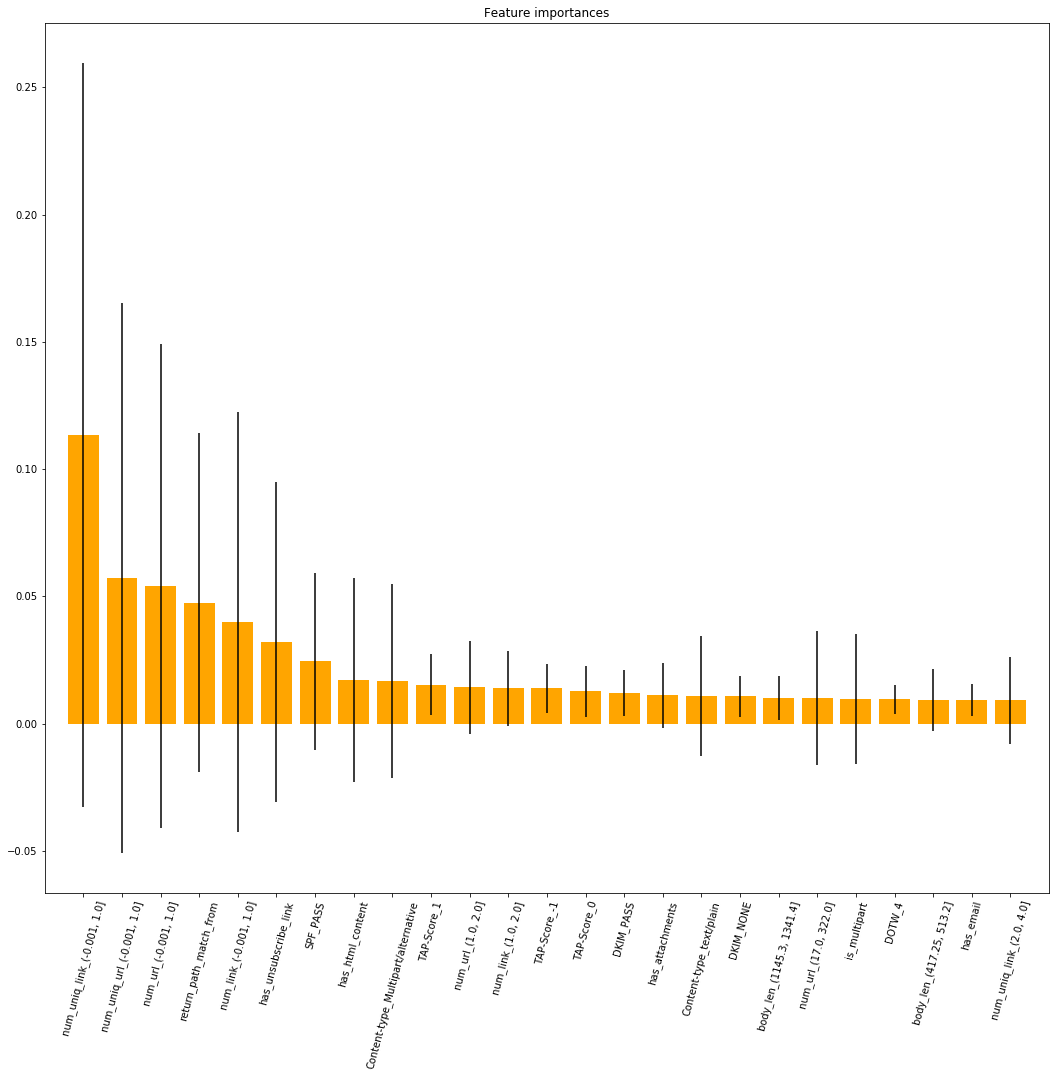

In [29]:
top_indices = indices[:25]
top_features = [features[i] for i in indices[:25]]
plt.figure(figsize=(18, 16))
plt.title("Feature importances")
plt.bar(range(25), importances[top_indices],color="orange", yerr=std[top_indices], align="center",)
plt.xticks(range(25), top_features, rotation=75)
plt.xlim([-1, 25])
plt.show()

#### Gradient Boost

In [30]:
from sklearn.ensemble import GradientBoostingClassifier
t0 = time()
gb_clf = GradientBoostingClassifier(n_estimators=100,random_state=7350)
gb_clf.fit(train_feats, train_labels)
print("done in %0.3fs" % (time() - t0))
score_dict = scoring(score_dict,train_feats,train_labels,test_feats,test_labels,gb_clf)

done in 0.235s
GradientBoostingClassifier Scores:

Accuracy of data already seen: 0.9665
Accuracy of data not seen: 0.9045
F1 score: 0.9045
False Negatives: 4


#### XGBoost

In [31]:
# from xgboost import XGBClassifier
# t0 = time()
# xgb_clf = XGBClassifier(max_depth=5,random_state=7350,n_estimators=100,n_jobs=-1)
# xgb_clf.fit(train_feats, train_labels)
# #xgb_pred = xgb_clf.predict(test_feats)
# print("done in %0.3fs" % (time() - t0))

In [32]:
# xgb_clf.score(train_feats, train_labels)

In [33]:
# xgb_clf.score(test_feats, test_labels)

#### Neural Net

In [34]:
from sklearn.neural_network import MLPClassifier
t0 = time()
nn_clf = MLPClassifier(max_iter=800)
nn_clf.fit(train_feats, train_labels)
print("done in %0.3fs" % (time() - t0))
score_dict = scoring(score_dict,train_feats,train_labels,test_feats,test_labels,nn_clf)

done in 1.001s
MLPClassifier Scores:

Accuracy of data already seen: 1.0000
Accuracy of data not seen: 0.9236
F1 score: 0.9221
False Negatives: 4


#### Naive Bayes

In [35]:
from sklearn.naive_bayes import MultinomialNB
t0 = time()
nb_clf = MultinomialNB(alpha=.001)
nb_clf.fit(train_feats, train_labels)
print("done in %0.3fs" % (time() - t0))
score_dict = scoring(score_dict,train_feats,train_labels,test_feats,test_labels,nb_clf)

done in 0.004s
MultinomialNB Scores:

Accuracy of data already seen: 0.8724
Accuracy of data not seen: 0.9045
F1 score: 0.9057
False Negatives: 3


In [36]:
from sklearn.naive_bayes import GaussianNB
t0 = time()
gnb_clf = GaussianNB()
gnb_clf.fit(train_feats, train_labels)
print("done in %0.3fs" % (time() - t0))
score_dict = scoring(score_dict,train_feats,train_labels,test_feats,test_labels,gnb_clf)

done in 0.007s
GaussianNB Scores:

Accuracy of data already seen: 0.6730
Accuracy of data not seen: 0.6433
F1 score: 0.4167
False Negatives: 55


#### Random Forest

In [37]:
from sklearn.ensemble import RandomForestClassifier
t0 = time()
rf_clf = RandomForestClassifier(n_jobs=-1,n_estimators=100,random_state=7350)
rf_clf.fit(train_feats, train_labels)
print("done in %0.3fs" % (time() - t0))
score_dict = scoring(score_dict,train_feats,train_labels,test_feats,test_labels,rf_clf)

done in 0.200s
RandomForestClassifier Scores:

Accuracy of data already seen: 1.0000
Accuracy of data not seen: 0.9236
F1 score: 0.9241
False Negatives: 2


In [38]:
importances = rf_clf.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf_clf.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]
features = df.drop('target',axis=1).columns
print("Feature ranking:")
for f in range(25):
    print("%d. %s (%f)" % (f + 1, features[indices[f]], importances[indices[f]]))

Feature ranking:
1. num_uniq_link_(-0.001, 1.0] (0.097739)
2. num_uniq_url_(-0.001, 1.0] (0.067430)
3. num_url_(-0.001, 1.0] (0.066048)
4. return_path_match_from (0.054941)
5. num_link_(-0.001, 1.0] (0.041483)
6. has_unsubscribe_link (0.027969)
7. Content-type_Multipart/alternative (0.026823)
8. SPF_PASS (0.019002)
9. TAP-Score_1 (0.016399)
10. num_link_(1.0, 2.0] (0.014496)
11. DKIM_PASS (0.013003)
12. DOTW_4 (0.011906)
13. TAP-Score_-1 (0.011613)
14. num_uniq_link_(2.0, 4.0] (0.011244)
15. TAP-Score_0 (0.010809)
16. Content-type_text/plain (0.010292)
17. num_url_(1.0, 2.0] (0.010134)
18. from_tld_com (0.009267)
19. SPF_NONE (0.009166)
20. body_len_(417.25, 513.2] (0.009065)
21. is_multipart (0.008983)
22. DKIM_NONE (0.008872)
23. has_email (0.008864)
24. num_uniq_url_(1.0, 2.0] (0.008824)
25. has_html_content (0.008631)


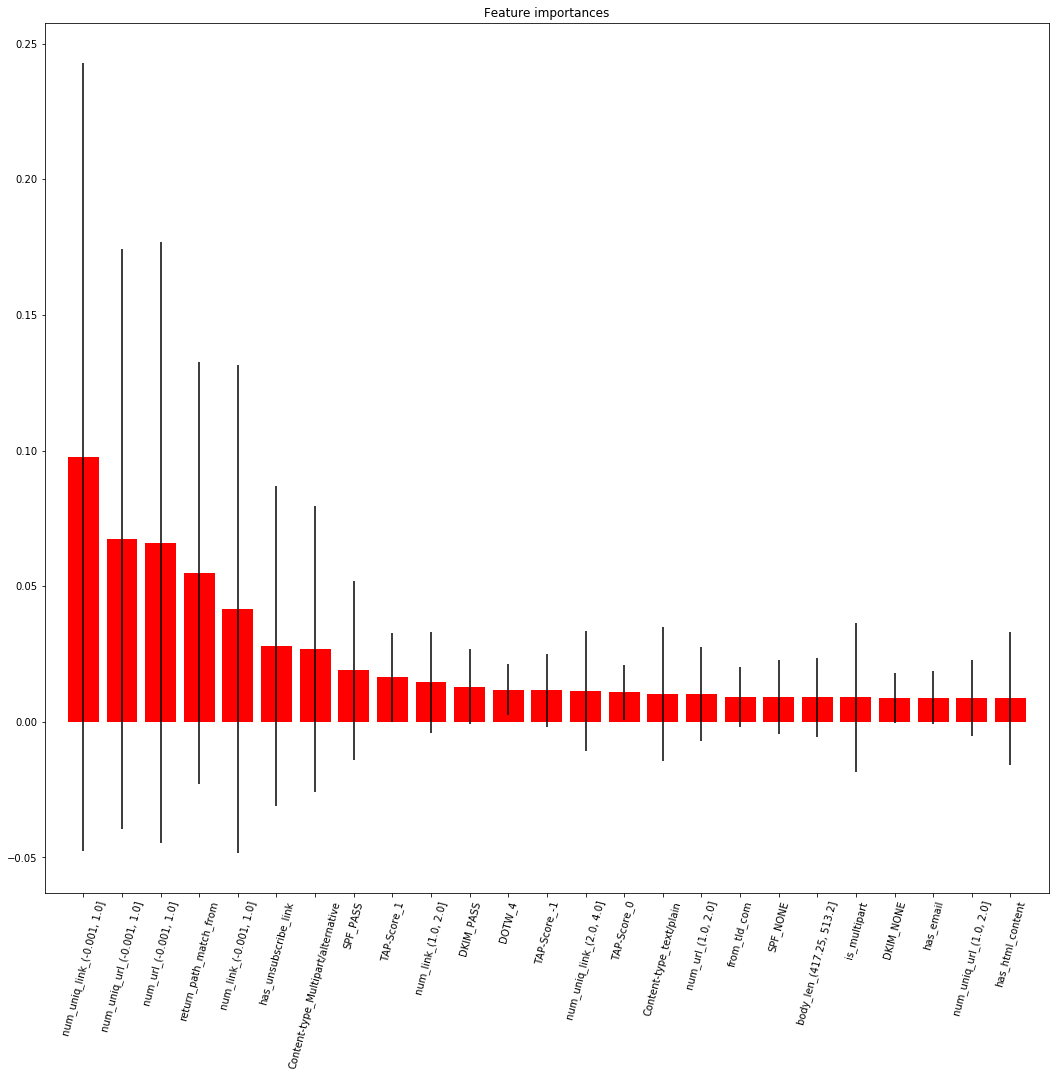

In [39]:
top_indices = indices[:25]
top_features = [features[i] for i in indices[:25]]
plt.figure(figsize=(18, 16))
plt.title("Feature importances")
plt.bar(range(25), importances[top_indices],color="red", yerr=std[top_indices], align="center",)
plt.xticks(range(25), top_features, rotation=75)
plt.xlim([-1, 25])
plt.show()

#### Nearest Neighbors

In [40]:
from sklearn.neighbors import KNeighborsClassifier
t0 = time()
knn_clf = KNeighborsClassifier(n_jobs=-1,leaf_size=100)
knn_clf.fit(train_feats, train_labels)
print("done in %0.3fs" % (time() - t0))
score_dict = scoring(score_dict,train_feats,train_labels,test_feats,test_labels,knn_clf)

done in 0.004s
KNeighborsClassifier Scores:

Accuracy of data already seen: 0.8979
Accuracy of data not seen: 0.9108
F1 score: 0.9114
False Negatives: 3


#### NearestCentroid

In [41]:
from sklearn.neighbors import NearestCentroid
t0 = time()
nc_clf = NearestCentroid()
nc_clf.fit(train_feats, train_labels)
print("done in %0.3fs" % (time() - t0))
score_dict = scoring(score_dict,train_feats,train_labels,test_feats,test_labels,nc_clf)

done in 0.004s
NearestCentroid Scores:

Accuracy of data already seen: 0.8325
Accuracy of data not seen: 0.8981
F1 score: 0.8961
False Negatives: 6


#### AdaBoost

In [42]:
from sklearn.ensemble import AdaBoostClassifier
t0 = time()
ab_clf = AdaBoostClassifier(n_estimators=100,random_state=7350)
ab_clf.fit(train_feats, train_labels)
print("done in %0.3fs" % (time() - t0))
score_dict = scoring(score_dict,train_feats,train_labels,test_feats,test_labels,ab_clf)

done in 0.209s
AdaBoostClassifier Scores:

Accuracy of data already seen: 0.9330
Accuracy of data not seen: 0.9172
F1 score: 0.9128
False Negatives: 7


#### QuadraticDiscriminantAnalysis

In [43]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
t0 = time()
qda_clf = QuadraticDiscriminantAnalysis()
qda_clf.fit(train_feats, train_labels)
print("done in %0.3fs" % (time() - t0))
score_dict = scoring(score_dict,train_feats,train_labels,test_feats,test_labels,qda_clf)

done in 0.057s
QuadraticDiscriminantAnalysis Scores:

Accuracy of data already seen: 0.8357
Accuracy of data not seen: 0.7580
F1 score: 0.6885
False Negatives: 33


/usr/local/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:682: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


#### GaussianProcessClassifier

In [44]:
from sklearn.gaussian_process import GaussianProcessClassifier
t0 = time()
gp_clf = GaussianProcessClassifier(random_state=7350)
gp_clf.fit(train_feats, train_labels)
print("done in %0.3fs" % (time() - t0))
score_dict = scoring(score_dict,train_feats,train_labels,test_feats,test_labels,gp_clf)

done in 0.239s
GaussianProcessClassifier Scores:

Accuracy of data already seen: 1.0000
Accuracy of data not seen: 0.9108
F1 score: 0.9114
False Negatives: 3


#### Decision Tree

In [45]:
from sklearn.tree import DecisionTreeClassifier
t0 = time()
dt_clf = DecisionTreeClassifier(random_state=7350)
dt_clf.fit(train_feats, train_labels)
print("done in %0.3fs" % (time() - t0))
score_dict = scoring(score_dict,train_feats,train_labels,test_feats,test_labels,dt_clf)

done in 0.009s
DecisionTreeClassifier Scores:

Accuracy of data already seen: 1.0000
Accuracy of data not seen: 0.8854
F1 score: 0.8831
False Negatives: 7


#### LogisticRegression

In [46]:
from sklearn.linear_model import LogisticRegression
t0 = time()
lr_clf = LogisticRegression(random_state=7350)
lr_clf.fit(train_feats, train_labels)
print("done in %0.3fs" % (time() - t0))
score_dict = scoring(score_dict,train_feats,train_labels,test_feats,test_labels,lr_clf)

done in 0.011s
LogisticRegression Scores:

Accuracy of data already seen: 0.9314
Accuracy of data not seen: 0.9236
F1 score: 0.9221
False Negatives: 4


#### PassiveAggressiveClassifier

In [47]:
from sklearn.linear_model import PassiveAggressiveClassifier
t0 = time()
pa_clf = PassiveAggressiveClassifier(n_jobs=-1,random_state=7350)
pa_clf.fit(train_feats, train_labels)
print("done in %0.3fs" % (time() - t0))
score_dict = scoring(score_dict,train_feats,train_labels,test_feats,test_labels,pa_clf)

done in 0.013s
PassiveAggressiveClassifier Scores:

Accuracy of data already seen: 0.7847
Accuracy of data not seen: 0.8025
F1 score: 0.7438
False Negatives: 30


/usr/local/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


#### RidgeClassifier

In [48]:
from sklearn.linear_model import RidgeClassifier
t0 = time()
rd_clf = RidgeClassifier(random_state=7350)
rd_clf.fit(train_feats, train_labels)
print("done in %0.3fs" % (time() - t0))
score_dict = scoring(score_dict,train_feats,train_labels,test_feats,test_labels,rd_clf)

done in 0.013s
RidgeClassifier Scores:

Accuracy of data already seen: 0.9378
Accuracy of data not seen: 0.9299
F1 score: 0.9262
False Negatives: 6


#### SGDClassifier

In [49]:
from sklearn.linear_model import SGDClassifier
t0 = time()
sgd_clf = SGDClassifier(random_state=7350)
sgd_clf.fit(train_feats, train_labels)
print("done in %0.3fs" % (time() - t0))
score_dict = scoring(score_dict,train_feats,train_labels,test_feats,test_labels,sgd_clf)

done in 0.005s
SGDClassifier Scores:

Accuracy of data already seen: 0.7687
Accuracy of data not seen: 0.7771
F1 score: 0.7009
False Negatives: 34


/usr/local/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


#### CalibratedClassifierCV

In [50]:
from sklearn.calibration import CalibratedClassifierCV
t0 = time()
cc_clf = CalibratedClassifierCV()
cc_clf.fit(train_feats, train_labels)
#cc_pred = cc_clf.predict(test_feats)
print("done in %0.3fs" % (time() - t0))
score_dict = scoring(score_dict,train_feats,train_labels,test_feats,test_labels,cc_clf)

done in 0.050s
CalibratedClassifierCV Scores:

Accuracy of data already seen: 0.9490
Accuracy of data not seen: 0.9045
F1 score: 0.9032
False Negatives: 5


#### BaggingClassifier

In [51]:
from sklearn.ensemble import BaggingClassifier
t0 = time()
bg_clf = BaggingClassifier(n_jobs=-1,n_estimators=100,random_state=7350)
bg_clf.fit(train_feats, train_labels)
#bg_pred = bg_clf.predict(test_feats)
print("done in %0.3fs" % (time() - t0))
score_dict = scoring(score_dict,train_feats,train_labels,test_feats,test_labels,bg_clf)

done in 0.306s
BaggingClassifier Scores:

Accuracy of data already seen: 1.0000
Accuracy of data not seen: 0.9108
F1 score: 0.9103
False Negatives: 4


#### VotingClassifier

In [66]:
from sklearn.ensemble import VotingClassifier
t0 = time()
vt_clf = VotingClassifier(estimators=[
    ('et',et_clf),
#     ('nn',nn_clf),
#     ('nb',nb_clf),
    #('rf',rf_clf),
    ('rd',rd_clf),
    #('bg',bg_clf),
#     ('cc',cc_clf),
#     ('svm',svm_clf),
    #('gp',gp_clf),
#     ('lr',lr_clf),
    #('gb',gb_clf),
#   ('ab',ab_clf),
])
vt_clf.fit(train_feats, train_labels)
print("done in %0.3fs" % (time() - t0))

done in 0.302s


In [67]:
already_seen = vt_clf.score(train_feats, train_labels)
accuracy = vt_clf.score(test_feats, test_labels)
vt_pred = vt_clf.predict(test_feats)
f1 = f1_score(test_labels, vt_pred, pos_label='investigate')
cnf_matrix = confusion_matrix(test_labels, vt_pred)
FN = cnf_matrix[1][0]
false_negative = cnf_matrix[1][0]
print('VotingClassifier Scores:\n')
print('Accuracy of data already seen: %0.4f' % already_seen)
print('Accuracy of data not seen: %0.4f' % accuracy)
print('F1 score: %0.4f' % f1)
print('False Negatives: %0d' % FN)

/usr/local/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


VotingClassifier Scores:

Accuracy of data already seen: 0.9665
Accuracy of data not seen: 0.9427
F1 score: 0.9388
False Negatives: 6


/usr/local/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


#### Best Classifier Scores

In [54]:
print('Best Accuracy:\n')
for i in [
    '%s: %0.4f' % (k,v)
    for k,v in sorted(score_dict['accuracy'], key=lambda tup: tup[1], reverse=True)
    ][:3]:
    print(i)
print('\n\nBest F1 Score:\n')
for i in [
    '%s: %0.4f' % (k,v)
    for k,v in sorted(score_dict['f1'], key=lambda tup: tup[1], reverse=True)
    ][:3]:
    print(i)
print('\n\nBest False Negative Classifier:\n')
for i in [
    '%s: %i' % (k,v)
    for k,v in sorted(score_dict['FN'], key=lambda tup: tup[1])
    ][:3]:
    print(i)

Best Accuracy:

ExtraTreesClassifier: 0.9363
RidgeClassifier: 0.9299
MLPClassifier: 0.9236


Best F1 Score:

ExtraTreesClassifier: 0.9351
RidgeClassifier: 0.9262
RandomForestClassifier: 0.9241


Best False Negative Classifier:

RandomForestClassifier: 2
ExtraTreesClassifier: 3
MultinomialNB: 3


#### Confusion Matrix and ROC curves of Top Algos

In [55]:
#http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    #fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [56]:
def display_conf_mat(clf,test_feats,test_labels):
    clf_name = re.findall('(^[^\(]+)\(',str(clf))[0]
    pred = clf.predict(test_feats)
    cnf_matrix = confusion_matrix(test_labels, pred)
    np.set_printoptions(precision=2)
    plt.figure(figsize=(5, 4))
    plot_confusion_matrix(cnf_matrix, classes=['ignore','investigate'],
                          title=clf_name + ' Confusion matrix')
    plt.show()   

In [57]:
#https://datamize.wordpress.com/2015/01/24/how-to-plot-a-roc-curve-in-scikit-learn/
#https://plot.ly/scikit-learn/plot-roc/
def plot_roc_curve(clf,test_feats,test_labels):
    clf_name = re.findall('(^[^\(]+)\(',str(clf))[0]
    # Binarize the output
    pred = clf.predict(test_feats)
    test_labels_bin = label_binarize(test_labels, classes=['ignore','investigate'])
    pred_bin = label_binarize(pred, classes=['ignore','investigate'])
    false_positive_rate, true_positive_rate, thresholds = roc_curve(test_labels_bin, pred_bin)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    plt.title(clf_name + ' Receiver Operating Characteristic')
    plt.plot(false_positive_rate, true_positive_rate, 'b',
        label='AUC = %0.2f'% roc_auc)
    plt.legend(loc='lower right')
    plt.plot([0,1],[0,1],'r--')
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

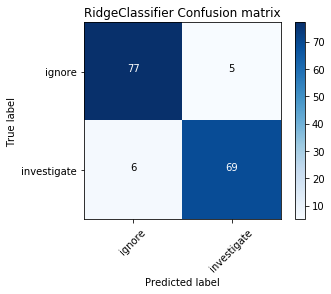

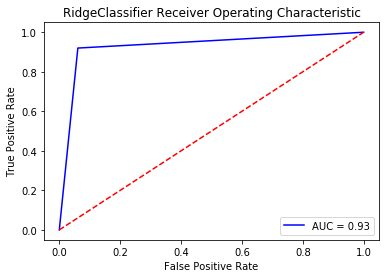

In [58]:
display_conf_mat(rd_clf,test_feats,test_labels)
plot_roc_curve(rd_clf,test_feats,test_labels)

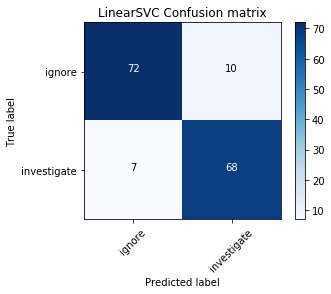

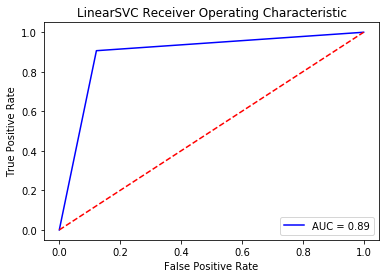

In [59]:
display_conf_mat(svm_clf,test_feats,test_labels)
plot_roc_curve(svm_clf,test_feats,test_labels)

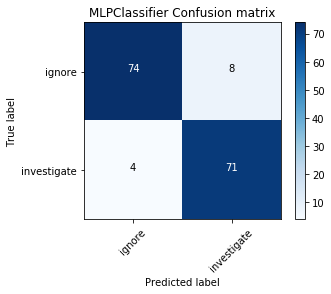

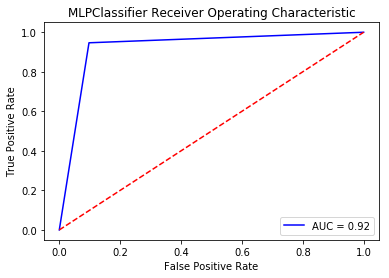

In [60]:
display_conf_mat(nn_clf,test_feats,test_labels)
plot_roc_curve(nn_clf,test_feats,test_labels)

/usr/local/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


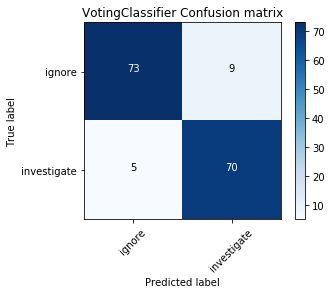

/usr/local/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


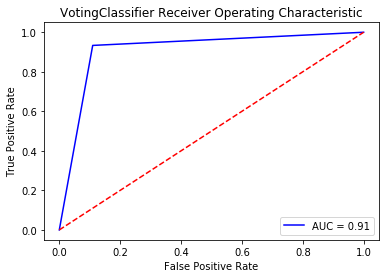

In [61]:
display_conf_mat(vt_clf,test_feats,test_labels)
plot_roc_curve(vt_clf,test_feats,test_labels)